# Predictive Modeling

##### Setup and preparations

In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# set random seed for all algos
rseed = 42

# suppress future warnings for xgboost in this notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting style for plots later on
plt.style.use("seaborn")

pd.options.display.float_format = '{:.2f}'.format

In [42]:
def plot_hist(df, feature, title):
    
    feature_mean = round(df[f"{feature}"].mean()).astype("int64")

    plt.figure(figsize=(15,5))

    ax = sns.distplot(df[f"{feature}"], bins = 20, kde=False)

    plt.ticklabel_format(style='plain', axis='x')
    ax.tick_params(labelsize=14)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.axvline(feature_mean, color='b', linestyle='dashed', linewidth=2, ymax=0.95, label="Mean")

    ax.set_ylabel("count", fontsize = 16)
    ax.set_xlabel(f"{feature}", fontsize = 16)
    ax.set_title(f"{title}",fontsize = 20)
    
    ### text box, for fast visualisation of key values
    
    # defining key values for texr box
    min_value = round(df[f"{feature}"].min()).astype("int64")
    max_value = round(df[f"{feature}"].max()).astype("int64")
    mean_value = round(df[f"{feature}"].mean()).astype("int64")
    
    # put key values in joined text-string
    textstr = '\n'.join((
        f"min value = {min_value:0,}",
        f"max value = {max_value:0,}",
        f"mean value = {mean_value:0,}"))
    
    # define box style
    props = dict(boxstyle='round', facecolor='blue', alpha=0.2)

    # place text box on the right with x and y coordinates
    ax.text(0.75, 0.6, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='center', bbox=props)

    
    if feature == "market_value_€":
        
        import matplotlib.ticker as plticker
        
        plt.xticks(rotation='vertical')

        #set tick every 10 Mio €
        tick_spacing = 10000000
        loc = plticker.MultipleLocator(tick_spacing)
        ax.xaxis.set_major_locator(loc)
        
        plt.legend(prop={'size': 15})
        plt.show();
    
    else:
        plt.legend(prop={'size': 15})
        plt.show();

##### Prepare datasets for prediction

In [76]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)
df_fp["market_value_in_euro_log"] = np.log(df_fp["market_value_in_euro"])
df_gk["market_value_in_euro_log"] = np.log(df_gk["market_value_in_euro"])
df_fp.head()

,market_value_in_euro,player_name,long_name,year_of_birth,player_age,height_cm,weight_kg,nationality,geographical_continent,main_position,positional_flexibility,club,league,division,current_national_player,national_team_appearances,overall,preferred_foot,weak_foot,attacking_work_rate,defensive_work_rate,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,attack_positions_avg_score,midfield_attack_positions_avg_score,idfield_defense_positions_avg_score,defense_positions_avg_score,market_value_in_euro_log
0,12000000.00,Luka Modric,Luka Modrić,1985,34,172,66,Croatia,Europe,Centre Midfield,Low,Real Madrid,LaLiga (ESP),1,True,127,90,Right,4 Stars,High,High,4 Star Moves,74,76,89,89,72,66,86,72,55,92,76,87,85,78,88,92,77,71,92,89,93,79,68,85,58,82,62,82,79,91,82,92,68,76,71,81,85,84,76,16.30
1,4000000.00,Giorgio Chiellini,Giorgio Chiellini,1984,35,187,85,Italy,Europe,Centre Back,Low,Juventus Turin,Serie A (ITA),1,False,103,89,Left,3 Stars,Medium,High,2 Star Moves,68,46,58,60,90,82,54,33,83,65,45,59,60,31,65,61,61,73,57,82,57,78,89,59,89,49,91,88,28,50,50,84,94,91,89,56,56,67,79,15.20
2,14500000.00,Sergio Ramos,Sergio Ramos García,1986,34,184,82,Spain,Europe,Centre Back,Low,Real Madrid,LaLiga (ESP),1,True,170,89,Right,3 Stars,High,Medium,3 Star Moves,72,68,75,73,87,85,66,63,92,80,69,65,74,72,83,83,74,71,78,87,66,79,93,80,85,62,90,88,67,71,86,84,85,87,90,73,73,79,83,16.49
3,8000000.00,Diego Godín,Diego Godín,1986,34,187,78,Uruguay,South America,Centre Back,Low,Inter Mailand,Serie A (ITA),1,True,135,88,Right,3 Stars,Medium,High,2 Star Moves,60,48,64,61,89,83,52,42,88,79,47,53,49,49,70,74,61,60,57,81,53,67,90,65,89,43,88,87,48,52,50,82,90,89,87,60,61,71,80,15.89
4,20000000.00,Edinson Cavani,Edinson Roberto Cavani Gómez,1987,33,185,77,Uruguay,South America,Striker,Low,FC Paris Saint-Germain,Ligue 1 (FRA),1,True,116,88,Right,4 Stars,High,High,3 Star Moves,75,86,72,79,55,83,70,88,89,78,90,79,77,76,52,81,74,76,74,91,59,88,88,91,79,79,84,54,93,77,85,80,57,48,39,83,79,71,66,16.81


In [68]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)

pd.set_option('display.max_columns', None)

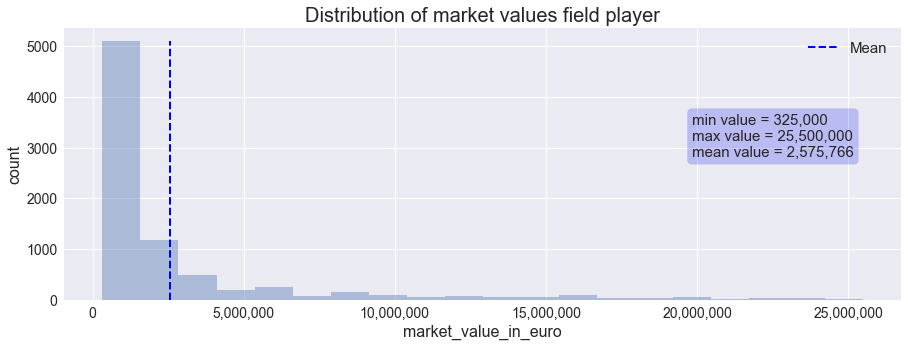

None


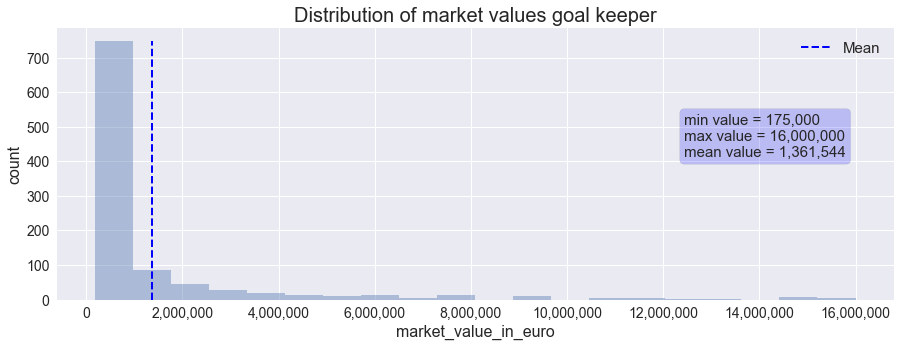

None


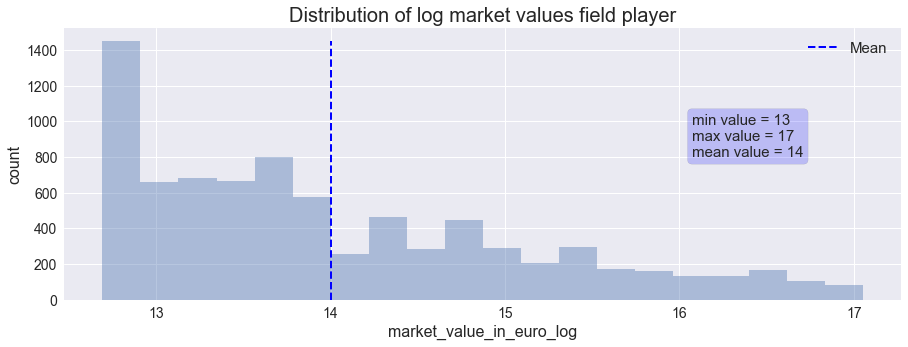

None


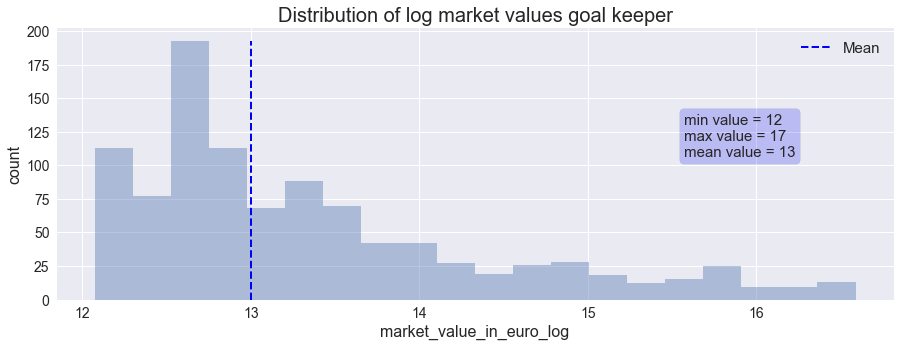

None


In [43]:
# truncate dataframe to cut of lower quartile
df_fp = df_fp[df_fp.market_value_in_euro > 300000]
df_gk = df_gk[df_gk.market_value_in_euro > 150000]

# drop irrelevant rows

df_fp = df_fp.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)
df_gk = df_gk.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

# transform target variable
print(plot_hist(df_fp,"market_value_in_euro","Distribution of market values field player"))
print(plot_hist(df_gk,"market_value_in_euro","Distribution of market values goal keeper"))

# since target variable is highly skewed, let's apply a log on it
df_fp["market_value_in_euro_log"] = np.log(df_fp["market_value_in_euro"])
df_gk["market_value_in_euro_log"] = np.log(df_gk["market_value_in_euro"])

df_fp = df_fp.drop(["market_value_in_euro"], axis = 1)
df_gk = df_gk.drop(["market_value_in_euro"], axis = 1)

print(plot_hist(df_fp,"market_value_in_euro_log","Distribution of log market values field player"))
print(plot_hist(df_gk,"market_value_in_euro_log","Distribution of log market values goal keeper"))

In [44]:
# final training sets
# fieldplayers
train_set_fp = df_fp.copy()

# goal keepers
train_set_gk = df_gk.copy()

print("Fieldplayers: ")
print(train_set_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)

Fieldplayers: 
(8032, 54)
-----------------------
Goalkeepers: 
(1007, 37)


## Feature Selection

##### Check for correlations before processing with heatmap

In [5]:
def plot_heatmap (data):
    
    corrmat = data.corr()
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 10))
        ax.xaxis.tick_top() 
        cmap = sns.color_palette("RdBu_r", 10)
        matrix = np.tril(corrmat)
        
    if len(data.columns) < 15:
    
        sns.set(context="paper", font="monospace", font_scale=2)

        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 12}, fmt='.2g', mask=matrix, linewidths=1, rasterized=True);
    
    elif len(data.columns) <= 30:
        
        sns.set(context="paper", font="monospace", font_scale=1.5)
        
        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 10}, fmt='.1g', mask=matrix, linewidths=1, rasterized=True);
    
    else:
        
        sns.set(context="paper", font="monospace", font_scale=1)

        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 8}, fmt='.1g', mask=matrix, linewidths=1, rasterized=True);

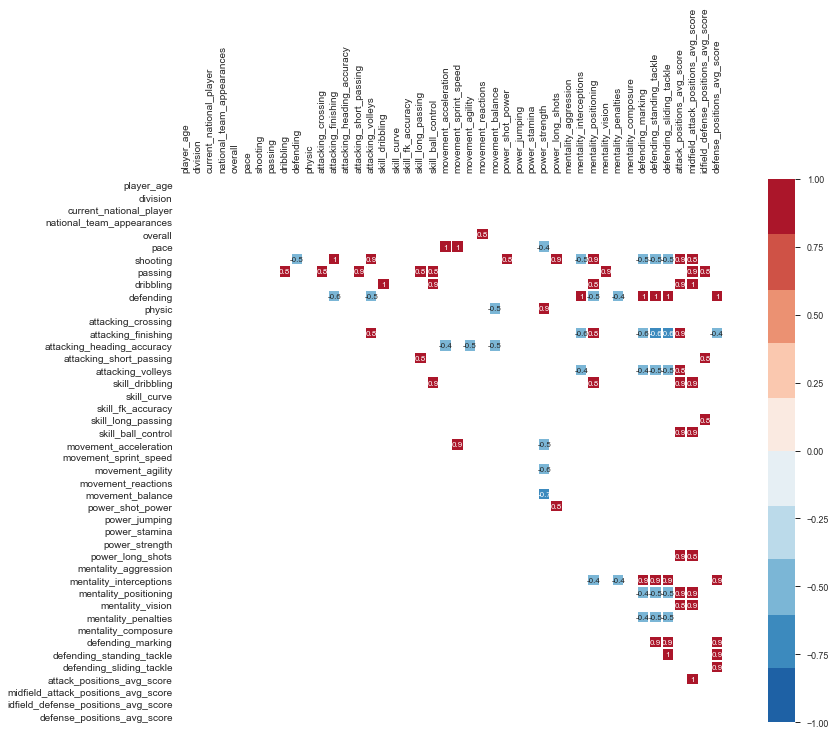

In [6]:
plot_heatmap(train_set_fp.drop(["market_value_in_euro_log"],axis=1))

In [7]:
correlated_features_fp = set()
correlation_matrix_fp = train_set_fp.corr()

for i in range(len(correlation_matrix_fp.columns)):
    for j in range(i):
        if abs(correlation_matrix_fp.iloc[i, j]) > 0.8:
            colname = correlation_matrix_fp.columns[i]
            correlated_features_fp.add(colname)

print(len(correlated_features_fp))            
print(sorted(correlated_features_fp, reverse=False))

24
['attack_positions_avg_score', 'attacking_crossing', 'attacking_finishing', 'attacking_short_passing', 'attacking_volleys', 'defending_marking', 'defending_sliding_tackle', 'defending_standing_tackle', 'defense_positions_avg_score', 'dribbling', 'idfield_defense_positions_avg_score', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'midfield_attack_positions_avg_score', 'movement_acceleration', 'movement_reactions', 'movement_sprint_speed', 'power_long_shots', 'power_shot_power', 'power_strength', 'skill_ball_control', 'skill_dribbling', 'skill_long_passing']


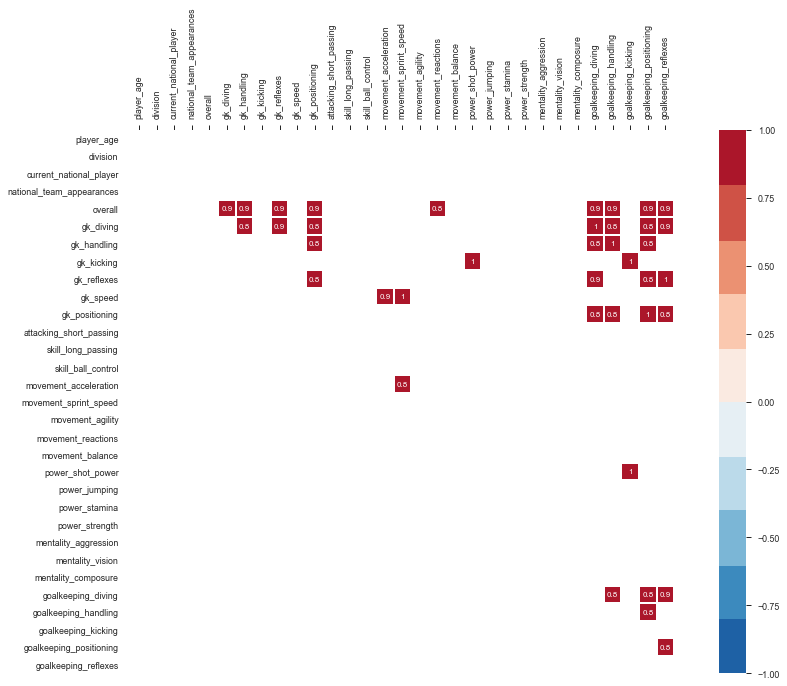

In [8]:
plot_heatmap(train_set_gk.drop(["market_value_in_euro_log"],axis=1))

In [9]:
correlated_features_gk = set()
correlation_matrix_gk = train_set_gk.corr()

for i in range(len(correlation_matrix_gk.columns)):
    for j in range(i):
        if abs(correlation_matrix_gk.iloc[i, j]) > 0.8:
            colname = correlation_matrix_gk.columns[i]
            correlated_features_gk.add(colname)

print(len(correlated_features_gk))            
print(sorted(correlated_features_gk, reverse=False))

13
['gk_diving', 'gk_handling', 'gk_positioning', 'gk_reflexes', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'movement_acceleration', 'movement_reactions', 'movement_sprint_speed', 'power_shot_power']


In [45]:
# drop highly correlated features for both dataframes
df_fp = df_fp.drop(df_fp.loc[:,'attacking_crossing':'defense_positions_avg_score'].columns, axis = 1)
df_gk = df_gk.drop(df_gk.loc[:,'gk_diving':'goalkeeping_reflexes'].columns, axis = 1)

# fieldplayers
train_set_fp = df_fp.copy()

# goal keepers
train_set_gk = df_gk.copy()


print("Fieldplayers: ")
print(train_set_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)

Fieldplayers: 
(8032, 21)
-----------------------
Goalkeepers: 
(1007, 11)


## Define Pipelines

### Preprocessing Pipeline

In [46]:
def preprocessing_pipeline (train_set, scaler, encoder):

    ######################################################################
    # I. train-test-split
    ######################################################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro_log"],axis=1)

    y = train_set["market_value_in_euro_log"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # II. Build preprocessing pipeline with
    # - a scaler for numerical columns
    # - an encoder for categorical columns
    # --> scaler and encoder need to be imported before function is called
    ###################################

    from sklearn.pipeline import Pipeline  

    numeric_transformer = Pipeline(steps=[
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('encoder', encoder)])

    ######################################################################
    # III. Apply column transformer
    ######################################################################

    from sklearn.compose import ColumnTransformer

    numerical_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro_log"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)])
    
    X_train_pre = preprocessor.fit_transform(X_train)
    X_test_pre = preprocessor.fit_transform(X_test)
    
    ######################################################################
    # IV. Extract column names for feature importances later on
    ######################################################################
    
    
    numerical_features_names = list(numerical_features)
    encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
    encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
    column_names = numerical_features_names + encoded_categorical_features_names

    return X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor  

### Model Selection Pipeline

Regressors to be tested:
1. Linear Regression
6. Stochastic Gradient Descent
7. Decision Trees
8. Random Forest
9. AdaBoost
10. Gradient Tree Boosting
11. XGBoost


##### build function to print all relevant regression metrics

In [118]:
def metrics_calculation(y_train, y_pred_train, y_test, y_pred_test):
    
    
    from sklearn.metrics import median_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    import math
    from math import sqrt
    
    mae_train = median_absolute_error(y_train, y_pred_train)
    mae_test = median_absolute_error(y_test, y_pred_test)
    
    mrse_train = math.sqrt(mean_squared_error(y_train, y_pred_train))
    mrse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r_squared_train = r2_score(y_train, y_pred_train)
    r_squared_test = r2_score(y_test, y_pred_test)
    
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train))
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test))

    
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Train median absolute error:")
    print(mae_train)
    print ("Test median absolute error:")
    print(mae_test)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Train mean root squared error:")
    print(mrse_train)
    print ("Test mean root squared error:")
    print(mrse_test)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Train mean absolute percentage error:")
    print(mape_train)
    print ("Test mean absolute percentage error:")
    print(mape_test)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Train R-squared:")
    print(r_squared_train)
    print ("Test R-squared:")
    print(r_squared_test)

##### Baseline model (linear regression)

In [52]:
def baseline_model (preprocessor_pipeline):
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ######################################################################
    # I. Define and import relevant algorithms
    ######################################################################

    from sklearn import linear_model
    from sklearn.pipeline import Pipeline  
        
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', linear_model.LinearRegression())])
        
    pipe.fit(X_train, y_train)
    
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    metrics_calculation(y_train, y_pred_train, y_test, y_pred_test)

In [53]:
# Linear Regression Baseline model
baseline_model(preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()))

------------------------------------------
------------------------------------------
Train mean absolute error:
0.445691939787083
Test mean absolute error:
0.4516799862585119
------------------------------------------
------------------------------------------
Train mean root squared error:
0.5685616359245345
Test mean root squared error:
0.5796934713318386
------------------------------------------
------------------------------------------
Train mean absolute percentage error:
0.03175544901037312
Test mean absolute percentage error:
0.032057131414759965
------------------------------------------
------------------------------------------
Train R-squared:
0.7369857731707499
Test R-squared:
0.7330993447705454


In [47]:
def model_selection_pipeline (preprocessor_pipeline, scoring="r2"):
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ######################################################################
    # I. Define and import relevant algorithms
    ######################################################################

    from sklearn import linear_model
    from sklearn import svm
    from sklearn import tree
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("Linear Regression",linear_model.LinearRegression()))
    models.append(("SGD",linear_model.SGDRegressor(random_state=rseed)))
    models.append(("Decision Tree",tree.DecisionTreeRegressor(random_state=rseed)))
    models.append(("Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("AdaBoost",AdaBoostRegressor(random_state=rseed)))
    models.append(("GradientBoosting",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGBoost",xgb.XGBRegressor(objective="reg:squarederror" ,random_state=rseed)))
    

    results = []
    names = []
    scoring = scoring
    
    ######################################################################
    # II. Fit models and calculate metric for each model
    ######################################################################
    
    from sklearn.pipeline import Pipeline
    
    from sklearn import model_selection
    from sklearn.model_selection import cross_val_score
    import math
    
    for name,regressor in models:
        
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        
        pipe.fit(X_train, y_train)
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        cv_results = abs(model_selection.cross_val_score(pipe, X, y, cv=kfold, scoring=scoring))
        cv_mean = math.ceil(cv_results.mean())
        cv_std = math.ceil(cv_results.std())
        results.append(cv_results)
        names.append(name)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

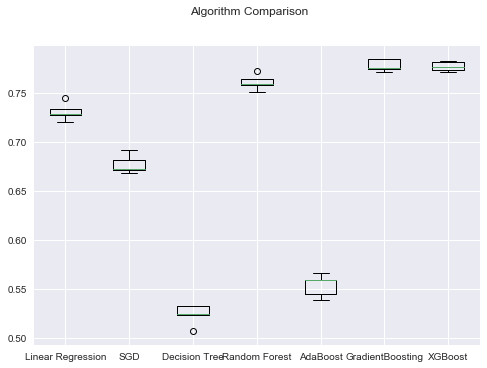

In [48]:
model_selection_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()))

##### --> Best 3 performing algorithms (in terms of R-squared) are Random Forest, GradientBoost and XGBoost!

## RandomizedSearchCV Pipeline

##### narrow down, where to look for with a gridsearch (not applicable for linear Regression)

In [8]:
def randomsearch_pipeline(preprocessor_pipeline, model_name, model, param_distributions, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor  = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import RandomizedSearchCV
    
    param_distributions = param_distributions
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = RandomizedSearchCV(pipe, param_distributions = param_distributions, n_iter = 100, cv=3, scoring=scoring, random_state=rseed, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")
    print("Best score:")
    print(grid.best_score_)
    print("-----------------------")

In [15]:
from sklearn.ensemble import RandomForestRegressor

param_distributions ={
'model__bootstrap': [True, False],
'model__max_depth': [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'model__max_features': ['auto', 'sqrt'],
'model__min_samples_leaf': [1, 2, 4, 6],
'model__min_samples_split': [1, 2, 5, 10],
'model__n_estimators': [1, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_distributions)

----------------------------------------------------------------------------------------------------------
 Random Forest 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': 60, 'model__bootstrap': True}
-----------------------
Best score:
0.7503829810294005
-----------------------


In [16]:
from sklearn.ensemble import GradientBoostingRegressor

param_distributions ={
    'model__learning_rate': [0.15,0.1,0.03, 0.05,0.07, 0.01,0.005,0.001],
    'model__n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'model__max_depth':[1,2,3,4,5,6,7],
    'model__min_samples_split':[1,2,4,6,8,10,20,40,60,80, 100],
    'model__min_samples_leaf':[1,3,5,7,9,11,13,15],
    'model__max_features':[1,2,3,4,5,6,7],
    'model__subsample':[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "GradientBoosting",GradientBoostingRegressor(random_state=rseed),param_distributions)

----------------------------------------------------------------------------------------------------------
 GradientBoosting 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.65, 'model__n_estimators': 1750, 'model__min_samples_split': 6, 'model__min_samples_leaf': 7, 'model__max_features': 7, 'model__max_depth': 3, 'model__learning_rate': 0.03}
-----------------------
Best score:
0.7779101718902052
-----------------------


In [17]:
import xgboost as xgb

param_distributions ={
    "model__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30] ,
    "model__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "model__min_child_weight": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "model__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
    "model__colsample_bytree":[ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9],
    "model__subsample":[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1],
    "model__reg_alpha":[1e-5, 1e-2, 0.1, 0.5, 1, 10, 50, 100]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "XGBoost",xgb.XGBRegressor(objective= "reg:squarederror", random_state=rseed),param_distributions)

----------------------------------------------------------------------------------------------------------
 XGBoost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.8, 'model__reg_alpha': 0.1, 'model__min_child_weight': 15, 'model__max_depth': 8, 'model__learning_rate': 0.07, 'model__gamma': 0.3, 'model__colsample_bytree': 0.9}
-----------------------
Best score:
0.7837507667432754
-----------------------


## GridSearchCV Pipeline

##### now use parameters from randomizedsearch pipeline

In [10]:
def gridsearch_pipeline(preprocessor_pipeline, model_name, model, param_grid, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import GridSearchCV
    
    param_grid = param_grid
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring=scoring, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")
    print("Best score:")
    print(grid.best_score_)
    print("-----------------------")

    # features importances

    feature_importances = grid.best_estimator_.named_steps["model"].feature_importances_
    feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
    feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
    print("Feature importances:")
    print("------------------------------------------------------------")
    print(feat_imp_df.head(30))
    print("------------------------------------------------------------")
    print("------------------------------------------------------------")
    
    # Regression metrics
    
    metrics_calculation(y_train, y_pred_train, y_test, y_pred_test)

In [21]:
from sklearn.ensemble import RandomForestRegressor

param_grid ={
'model__bootstrap': [True],
'model__max_depth': [55, 60, 65],
'model__max_features': ["auto"],
'model__min_samples_leaf': [2, 3, 4],
'model__min_samples_split': [13,15,17],
'model__n_estimators': [100,200,300]
}

gridsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_grid)

----------------------------------------------------------------------------------------------------------
 Random Forest 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__bootstrap': True, 'model__max_depth': 65, 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__min_samples_split': 17, 'model__n_estimators': 300}
-----------------------
Best score:
0.7514966205546815
-----------------------
Feature importances:
------------------------------------------------------------
                                 feature  importance
3                                overall        0.60
0                             player_age        0.22
52           league_Premier League (ENG)        0.02
8                              defending        0.01
5                               shooting        0.01
4                                   pace        0.01
56                  league_Serie A (ITA)    

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid ={
    'model__learning_rate': [0.01,0.02,0.03],
    'model__n_estimators':[1700,1750,1800],
    'model__max_depth':[2,3,4],
    'model__min_samples_split':[5,6,7],
    'model__min_samples_leaf':[6,7,8],
    'model__max_features':[7,9,11],
    'model__subsample':[0.6, 0.65, 0.7]
}

gridsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "GradientBoosting",GradientBoostingRegressor(random_state=rseed),param_grid)

----------------------------------------------------------------------------------------------------------
 GradientBoosting 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__learning_rate': 0.02, 'model__max_depth': 4, 'model__max_features': 11, 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 1700, 'model__subsample': 0.6}
-----------------------
Best score:
0.7842572246296493
-----------------------
Feature importances:
------------------------------------------------------------
                                   feature  importance
3                                  overall        0.25
0                               player_age        0.15
7                                dribbling        0.10
8                                defending        0.09
5                                 shooting        0.06
52             league_Premier League (ENG)        0.06
6  

In [23]:
import xgboost as xgb

param_grid ={
    "model__learning_rate": [0.06, 0.07, 0.08] ,
    "model__max_depth": [7, 8, 9],
    "model__min_child_weight": [14, 15, 16],
    "model__gamma": [0.25 , 0.3, 0.35],
    "model__colsample_bytree":[0.85, 0.9, 0.95],
    "model__subsample":[0.78,0.8,0.82],
    "model__reg_alpha":[0.05, 0.1, 0.2]
}

gridsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "XGBoost",xgb.XGBRegressor(objective= "reg:squarederror", random_state=rseed),param_grid)

----------------------------------------------------------------------------------------------------------
 XGBoost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__colsample_bytree': 0.9, 'model__gamma': 0.3, 'model__learning_rate': 0.08, 'model__max_depth': 7, 'model__min_child_weight': 16, 'model__reg_alpha': 0.2, 'model__subsample': 0.8}
-----------------------
Best score:
0.7867139569266777
-----------------------
Feature importances:
------------------------------------------------------------
                                    feature  importance
3                                   overall        0.23
52              league_Premier League (ENG)        0.08
0                                player_age        0.05
56                     league_Serie A (ITA)        0.04
48                     league_Ligue 1 (FRA)        0.04
7                                 dribbling        0.03
30           

## Stacking Pipeline

##### use the 3 tuned algorithms in an ensemble stacker

In [119]:
def stacking_pipeline(preprocessor_pipeline):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb  
    

    estimators = [
                         
        ("RF", Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', 
                       RandomForestRegressor(random_state=rseed,
                                             n_jobs=-1,
                                             bootstrap=True,
                                             max_depth=65,
                                             max_features="auto",
                                             min_samples_leaf=2,
                                             min_samples_split=17,
                                             n_estimators=300))])),
        
        
        ("GDB", Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', 
                       GradientBoostingRegressor(random_state=rseed,
                                                 learning_rate=0.02,
                                                 n_estimators=1700,
                                                 max_depth=4,
                                                 min_samples_split=5,
                                                 min_samples_leaf=7,
                                                 max_features=11,
                                                 subsample=0.6))])),
        
        
        ("XGB", Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', 
                       xgb.XGBRegressor(objective= "reg:squarederror",
                                        random_state=rseed,
                                        learning_rate=0.08,
                                        max_depth=7,
                                        min_child_weight=16,
                                        model__gamma=0.3,
                                        model__colsample_bytree=0.9,
                                        model__subsample=0.8,
                                        model__reg_alpha=0.2))]))
    ]
                      

                      
                      
    from sklearn.ensemble import StackingRegressor
                      
    stacked_model = StackingRegressor(estimators=estimators,
                                      final_estimator=xgb.XGBRegressor(objective= "reg:squarederror",
                                                                       random_state=rseed))


    stacked_model.fit(X_train, y_train)
    

    y_pred_train = stacked_model.predict(X_train)
    y_pred_test = stacked_model.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m","Stacked Model","\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    # Regression metrics
    
    metrics_calculation(y_train, y_pred_train, y_test, y_pred_test) 
    
    return X_train, X_test, y_train, y_pred_train, y_test, y_pred_test

##### estimate field players and goalkeepers separately and then reconnect them with their respective predicted values

In [120]:
def reconnect_and_final_eval (stacking_pipeline):
    
    from sklearn.metrics import median_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    import math
    from math import sqrt
    
    X_train, X_test, y_train, y_pred_train, y_test, y_pred_test = stacking_pipeline
    
    X_train["y_actual"] = math.e ** y_train
    X_train["y_predicted"] = math.e ** y_pred_train
    X_train["residuals"] = X_train["y_actual"] - X_train["y_predicted"]
    
    X_test["y_actual"] = math.e ** y_test
    X_test["y_predicted"] = math.e ** y_pred_test
    X_test["residuals"] = X_test["y_actual"] - X_test["y_predicted"]
    
    df_final = X_train.append(X_test)
    df_final = df_final.sort_index()
    
    
    
    mae = median_absolute_error(df_final["y_actual"], df_final["y_predicted"])

    
    mrse = math.sqrt(mean_squared_error(df_final["y_actual"], df_final["y_predicted"]))

    
    r_squared = r2_score(df_final["y_actual"], df_final["y_predicted"])

    
    mape = np.mean(np.abs((df_final["y_actual"] - df_final["y_predicted"]) / df_final["y_actual"]))

    
    print("------------------------------------------")
    print("------------------------------------------")
    print("------------------------------------------")
    print("------------------------------------------")
    print("------------------------------------------")
    print("------------------------------------------")
    print("\033[1m","Rescaled Metrics","\033[0m")
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Median absolute error:")
    print(mae)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Mean root squared error:")
    print(mrse)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("Mean absolute percentage error:")
    print(mape)
    print("------------------------------------------")
    print("------------------------------------------")
    print ("R-squared:")
    print(r_squared)
    
    return df_final

In [121]:
df_fp_final = reconnect_and_final_eval(stacking_pipeline(preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder())))

----------------------------------------------------------------------------------------------------------
 Stacked Model 
----------------------------------------------------------------------------------------------------------
------------------------------------------
------------------------------------------
Train median absolute error:
0.24536772076533175
Test median absolute error:
0.30274747092855314
------------------------------------------
------------------------------------------
Train mean root squared error:
0.41998055411913665
Test mean root squared error:
0.5181794700400378
------------------------------------------
------------------------------------------
Train mean absolute percentage error:
0.022718359288173395
Test mean absolute percentage error:
0.027896299554661528
------------------------------------------
------------------------------------------
Train R-squared:
0.8564898887416765
Test R-squared:
0.7867381234020063
-----------------------------------------

In [122]:
df_fp_final["residuals"].describe()

count       8032.00
mean      258573.80
std      1766153.76
min     -9578033.00
25%      -208526.83
50%       -21709.44
75%       332179.44
max     20585862.87
Name: residuals, dtype: float64

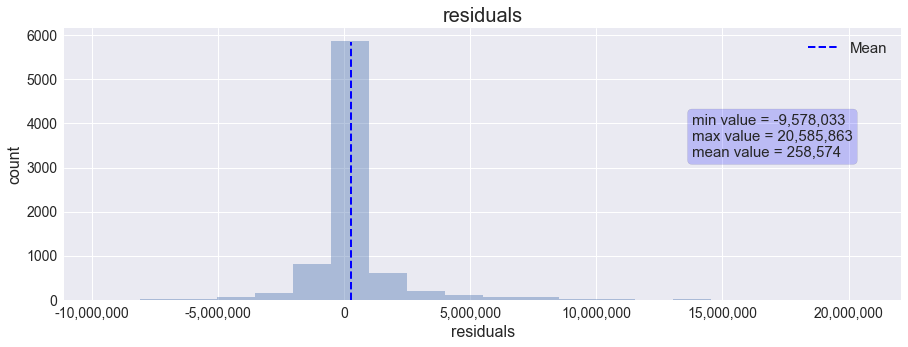

In [123]:
plot_hist(df_fp_final,"residuals", "residuals")

In [124]:
df_gk_final = reconnect_and_final_eval(stacking_pipeline(preprocessing_pipeline(train_set_gk, MinMaxScaler(), OneHotEncoder())))

----------------------------------------------------------------------------------------------------------
 Stacked Model 
----------------------------------------------------------------------------------------------------------
------------------------------------------
------------------------------------------
Train median absolute error:
0.26246182613695623
Test median absolute error:
0.3227030071912491
------------------------------------------
------------------------------------------
Train mean root squared error:
0.43648077946852654
Test mean root squared error:
0.5308185460054745
------------------------------------------
------------------------------------------
Train mean absolute percentage error:
0.024683754440225775
Test mean absolute percentage error:
0.029308574902048825
------------------------------------------
------------------------------------------
Train R-squared:
0.8356350476847918
Test R-squared:
0.7161828884464569
------------------------------------------

In [125]:
df_gk_final["residuals"].describe()

count       1007.00
mean      178336.23
std      1291977.99
min     -6817321.00
25%      -108049.81
50%       -13400.09
75%       155715.06
max     10815703.87
Name: residuals, dtype: float64

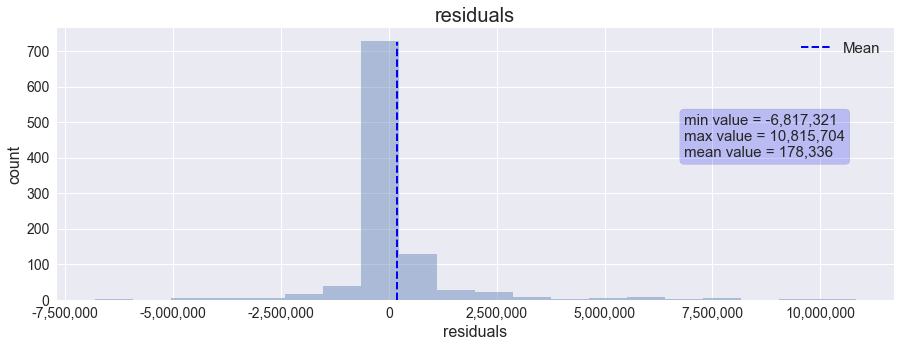

In [126]:
plot_hist(df_gk_final,"residuals", "residuals")

# Final data connection

##### rearrange and order the dataframes, and convert log market value back to euro values

In [135]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()    
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [136]:
df_fp_orig = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk_orig = pd.read_csv("data/gk_data_final.csv", index_col=0)

df_fp_orig = df_fp_orig.drop(df_fp_orig.loc[:,'attacking_crossing':'defense_positions_avg_score'].columns, axis = 1)
df_gk_orig = df_gk_orig.drop(df_gk_orig.loc[:,'gk_diving':'goalkeeping_reflexes'].columns, axis = 1)

df_fp_orig = df_fp_orig[df_fp_orig.market_value_in_euro > 300000]
df_gk_orig = df_gk_orig[df_gk_orig.market_value_in_euro > 150000]

print(df_fp_orig.shape)
print(df_gk_orig.shape)

(8032, 28)
(1007, 18)


In [137]:
df_fp_preds = df_fp_final.copy()
df_gk_preds = df_gk_final.copy()
print(df_fp_preds.shape)
print(df_gk_preds.shape)

(8032, 23)
(1007, 13)


In [138]:
df_fp_connected = df_fp_orig.copy()
df_gk_connected = df_gk_orig.copy()

In [141]:
df_fp_connected["predicted_market_value"] = df_fp_preds["y_predicted"].round()
df_fp_connected["difference"] = df_fp_preds["residuals"].round()

df_fp_connected = df_fp_connected.rename(columns={"market_value_in_euro": "actual_market_value",})

df_fp_connected["actual_market_value"] = df_fp_connected["actual_market_value"].astype("int64")
df_fp_connected["predicted_market_value"] = df_fp_connected["predicted_market_value"].astype("int64")
df_fp_connected["difference"] = df_fp_connected["difference"].astype("int64")

df_fp_connected = movecol(df_fp_connected, cols_to_move=["predicted_market_value","difference"], ref_col="actual_market_value", place="After")

In [142]:
df_gk_connected["predicted_market_value"] = df_gk_preds["y_predicted"].round()
df_gk_connected["difference"] = df_gk_preds["residuals"].round()

df_gk_connected = df_gk_connected.rename(columns={"market_value_in_euro": "actual_market_value",})

df_gk_connected["actual_market_value"] = df_gk_connected["actual_market_value"].astype("int64")
df_gk_connected["predicted_market_value"] = df_gk_connected["predicted_market_value"].astype("int64")
df_gk_connected["difference"] = df_gk_connected["difference"].astype("int64")

df_gk_connected = movecol(df_gk_connected, cols_to_move=["predicted_market_value","difference"], ref_col="actual_market_value", place="After")

##### Save

In [143]:
df_fp_connected.to_csv('data/fp_data_final_connected.csv')
df_gk_connected.to_csv('data/gk_data_final_connected.csv')